# Chi-squared

In [3]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"
import scipy.stats as stats                         # Statistical tests

import random
import math

import pandas as pd                                 # Data Frame
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt                     # Basic visualisation
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic diagram
import seaborn as sns                               # Advanced data visualisation

Formally, the procedure of the $\chi^2$ test for independence runs as follows:

1. Formulate the hypotheses:
   - $H_0$: There is no association between the variables (the differences between observed and expected values are small)
   - $H_1$: There is an association between the variables (the differences are large)
2. Choose significance level $\alpha$
3. Calculate the value of the test statistic in the sample (here: $\chi^2$).
4. Use one of the following methods (based on the degrees of freedom $df = (r-1) \times (k-1)$):
   1. Determine critical value $g$ so $P(\chi^2 > g) = \alpha$
   2. Calculate the $p$-value
5. Draw a conclusion based on the outcome:
   1. $\chi^2 < g$: do not reject $H_0$; $\chi^2 > g$: reject $H_0$
   2. $p > \alpha$: do not reject $H_0$; $p < \alpha$: reject $H_0$

In [4]:
rlanders = pd.read_csv('https://raw.githubusercontent.com/HoGentTIN/dsai-en-labs/main/data/rlanders.csv').set_index(['ID'])
rlanders.Gender = rlanders.Gender.astype('category')
likert_scale = CategoricalDtype(categories=[1,2,3,4,5], ordered=True)
rlanders.Survey = rlanders.Survey.astype(likert_scale)

# capture observed values
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
row_sums = observed.sum(axis=1)
col_sums = observed.sum()
n = row_sums.sum()

# calculate expected values from percentages of occurence
# ex. vote 3 = 114 / 250 = 0.456 (45.6%) = (women = 52 * 0.456 = 23.7 (vs 23))
# (men = 198 * 0.456 = 90.288 (vs 91))
expected = np.outer(row_sums, col_sums) / n
print(expected)
alpha = .05
dimensions = observed.shape

dof = (dimensions[0]-1) * (dimensions[1]-1)

diffs = (expected - observed)**2 / expected
chi_squared = diffs.values.sum()
print('χ² ≈ %.3f' %chi_squared)

print("Chi-squared        : %.4f" % chi_squared)
print("Degrees of freedom : %d" % dof)

# Calculate critical value
g = stats.chi2.isf(alpha, df = dof)
print("Critical value     : %.4f" % g)

# Calculate p-value
p = stats.chi2.sf(chi_squared, df=dof)
print("p-value            : %.4f" % p)

[[ 0.832  3.168]
 [12.896 49.104]
 [23.712 90.288]
 [13.52  51.48 ]
 [ 1.04   3.96 ]]
χ² ≈ 4.255
Chi-squared        : 4.2555
Degrees of freedom : 4
Critical value     : 9.4877
p-value            : 0.3725


### Chi squared to Cramers V

| Cramér's V | Interpretation          |
| :---:      | :---                    |
| 0          | No association          |
| 0.1        | Weak association        |
| 0.25       | Moderate association    |
| 0.50       | Strong association      |
| 0.75       | Very strong association |
| 1          | Complete association    |

In [14]:
dof = min(observed.shape) - 1
cramers_v = np.sqrt(chi_squared / (dof * n))
print(cramers_v)

0.05157185535752395


In [5]:
# Chi-squared test for independence based on a contingency table
observed = pd.crosstab(rlanders.Survey, rlanders.Gender)
chi2, p, dof, expected = stats.chi2_contingency(observed)
alpha = .05 

# Calculate critical value
g = stats.chi2.isf(alpha, df = dof)
print("Critical value     : %.4f" % g)
print("Chi-squared       : %.4f" % chi2)
print("Degrees of freedom: %d" % dof)
print("P-value           : %.4f" % p)
 

Critical value     : 9.4877
Chi-squared       : 4.2555
Degrees of freedom: 4
P-value           : 0.3725


In [ ]:
# Is there an association between Gender and Survey?

# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=dof)

# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(alpha, df=dof)  # TODO: CHECK this!

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange')  # chi-squared

Only a Right tailed test. When chi is > than critical value then reject H0

### Goodness of fit test

observed vs expected

The question now is: is this sample representative of the population? Does each type occur in the sample in proportion to the expected percentage in the population as a whole?

#### Test procedure

To answer these kinds of questions, a goodness-of-fit test is suitable. The procedure is as follows:

1. Formulate the hypotheses:
   - $H_0$: The sample is representative of the population, i.e. the frequency of each class within the sample corresponds well to that in the population.
   - $H_1$: The sample is *not* representative of the population, i.e. the differences with the expected frequencies are too large.
2. Choose significance level $\alpha$
3. Calculate the value of the test statistic in the sample (here: $\chi^2$).
4. Use one of the following methods (based on the degrees of freedom $df = (k-1)$ with $k$ the number of categories in the sample):
   1. Determine critical value $g$ so $P(\chi^2 > g) = \alpha$
   2. Calculate the $p$-value
5. Draw a conclusion based on the outcome:
   1. $\chi^2 < g$: do not reject $H_0$; $\chi^2 > g$: reject $H_0$
   2. $p > \alpha$: do not reject $H_0$; $p < \alpha$: reject $H_0$

A plot of this case, including the calculation of $p$ and $g$:


In [7]:
types =               ['mutant', 'human', 'alien', 'god', 'demon']
observed =   np.array([   127,      75,      98,     27,     73])
expected_p = np.array([   .35,     .17,     .23,    .08,    .17])

alpha = 0.05               # Significance level
n = sum(observed)          # Sample size
k = len(observed)          # Number of categories
dof = k - 1                # Degrees of freedom
expected = expected_p * n  # Expected absolute frequencies in the sample
g = stats.chi2.isf(alpha, df=dof)  # Critical value

# Goodness-of-fit-test in Python:
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

print("Significance level  ⍺ = %.2f" % alpha)
print("Sample size         n = %d" % n)
print("k = %d; df = %d" % (k, dof))
print("Chi-squared        χ² = %.4f" % chi2)
print("Critical value      g = %.4f" % g)
print("p-value             p = %.4f" % p)

Significance level  ⍺ = 0.05
Sample size         n = 400
k = 5; df = 4
Chi-squared        χ² = 3.4679
Critical value      g = 9.4877
p-value             p = 0.4828


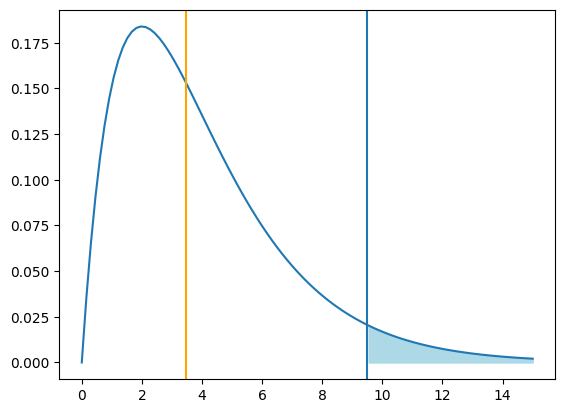

In [9]:
# Plot of the case:
# x-values:
x = np.linspace(0, 15, num=100)
# probability density of the chi-squared distribution with 4 degrees of freedom
y = stats.chi2.pdf(x, df=dof)
# the number q for which the right tail probability is exactly 5%:
q = stats.chi2.isf(alpha, df=dof)

fig, tplot = plt.subplots(1, 1)
tplot.plot(x, y)                     # probability density
tplot.fill_between(x, y, where=x>=q, # critical area
    color='lightblue')
tplot.axvline(q)                     # critical value
tplot.axvline(chi2, color='orange')  # chi-squared

## Standardised residuals

Standardised residuals are a measure of the extent to which a certain category is over- or under-represented in the sample. A value of 0 is given when the observed frequency is equal to the expected frequency. A negative value is given when there are fewer observations than expected and a positive value when there are more. As long as $r_i \in [-2, 2]$, we consider the differences to be random sampling errors.

A value $r_i < -2$ indicates underrepresentation of this category, $r_i > 2$ indicates overrepresentation.

In [13]:
stdres = (observed - expected) / np.sqrt(expected * (1 - expected_p))
print(types)
print(stdres)

['mutant', 'human', 'alien', 'god', 'demon']
[-1.36277029  0.93176102  0.71287268 -0.92151223  0.66554359]
